In [1]:
import cf_xarray
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xcmocean
import cmocean.cm as cmo
import extract_model as em

# Generically access model output

## ROMS

In [2]:
# open an example dataset from xarray's tutorials
ds = xr.tutorial.open_dataset('ROMS_example.nc', chunks={'ocean_time': 1})
# normally could run the `preprocess` code as part of reading in the dataset
# but with the tutorial model output, run it separately:
ds = em.preprocess(ds)
ds

# url = ['https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/CBOFS/fmrc/Aggregated_7_day_CBOFS_Fields_Forecast_best.ncd']
# ds = xr.open_mfdataset(url, preprocess=em.preprocess, drop_variables='ocean_time')
# ds

<xarray.Dataset>
Dimensions:     (eta_rho: 191, ocean_time: 2, s_rho: 30, xi_rho: 371)
Coordinates:
    Cs_r        (s_rho) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 371), meta=np.ndarray>
    hc          float64 20.0
    h           (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 371), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 371), meta=np.ndarray>
    Vtransform  int32 2
  * ocean_time  (ocean_time) datetime64[ns] 2001-08-01 2001-08-08
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 364 365 366 367 368 369 370
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 184 185 186 187 188 189 190
    z_rho       (ocean_time, s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 30, 191, 371), meta=np.ndarray>
Data variables:
    salt        (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 30, 191, 371), meta=np.ndarray>
    zeta        (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 191, 371), meta=np.ndarray>
Attributes: (12/34)
    file:              ../output_20yr_obc/2001/ocean_his_0015.nc
    format:            netCDF-4/HDF5 file
    Conventions:       CF-1.4
    type:              ROMS/TOMS history file
    title:             TXLA ROMS hindcast run with dyes and oxygen
    rst_file:          ../output_20yr_obc/2001/ocean_rst.nc
    ...                ...
    compiler_flags:    -heap-arrays -fp-model fast -mt_mpi -ip -O3 -msse2 -free
    tiling:            010x012
    history:           Tue Jul 24 11:04:43 2018: /opt/nco/ncks -D 4 -t 8 /cop...
    ana_file:          /home/d.kobashi/TXLA_ROMS_reana/Functionals/ana_btflux...
    CPP_options:       TXLA2, ANA_BPFLUX, ANA_BSFLUX, ANA_BTFLUX, ANA_NUDGCOE...
    NCO:               netCDF Operators version 4.7.6-alpha04 (Homepage = htt...

Note that the preprocessing code sets up a ROMS dataset so that it can be used with `cf-xarray`. For example, axis and coordinate variables have been identified:

In [3]:
ds.cf.describe()

Coordinates:
- CF Axes: * X: ['xi_rho']
           * Y: ['eta_rho']
           * Z: ['s_rho']
           * T: ['ocean_time']

- CF Coordinates:   longitude: ['lon_rho']
                    latitude: ['lat_rho']
                    vertical: ['z_rho']
                  * time: ['ocean_time']

- Cell Measures:   area, volume: n/a

- Standard Names:   latitude: ['lat_rho']
                    longitude: ['lon_rho']
                  * ocean_s_coordinate_g2: ['s_rho']
                  * time: ['ocean_time']

- Bounds:   n/a

Data Variables:
- Cell Measures:   area, volume: n/a

- Standard Names:   sea_surface_elevation: ['zeta']
                    sea_water_practical_salinity: ['salt']

- Bounds:   n/a



### Subset DataArray

Use `.em.subset()` to narrow the model area down using a bounding box.

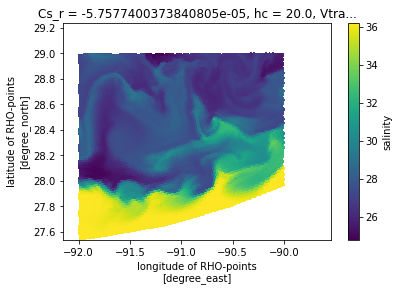

In [4]:
ds['salt'].em.subset([-92, 27, -90, 29], drop=True).cf.isel(T=0, Z=-1).cf.plot(x='longitude', y='latitude')

### grid point (interpolation and selecting nearest)

Interpolate to a single existing horizontal grid point (and any additional depth and time values for that location) and compare it with method selecting the nearest point to demonstrate we get the same value.

In [5]:
%%time
varname = 'salt'

# Set up a single lon/lat location
j, i = 50, 10
longitude = float(ds[varname].cf['longitude'][j,i])
latitude = float(ds[varname].cf['latitude'][j,i])

# Interpolation
da_out = ds[varname].em.interp2d(longitude, latitude)

# Selection of nearest location in 2D
da_check = ds[varname].em.sel2d(longitude, latitude)

assert np.allclose(da_out, da_check)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


CPU times: user 3.35 s, sys: 81.9 ms, total: 3.44 s
Wall time: 3.41 s


You could also select a time and/or depth index or interpolate in time and/or depth at the same time:

In [6]:
# Select time index and depth index
ds[varname].em.interp2d(longitude, latitude, iT=0, iZ=0)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


<xarray.DataArray 'salt' ()>
dask.array<getitem, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    Cs_r        float64 dask.array<chunksize=(), meta=np.ndarray>
    hc          float64 20.0
    Vtransform  int32 2
    ocean_time  datetime64[ns] 2001-08-01
    s_rho       float64 -0.9833
    lon         float64 -93.59
    lat         float64 28.23
    z_rho       float64 dask.array<chunksize=(), meta=np.ndarray>
Attributes:
    long_name:      salinity
    time:           ocean_time
    field:          salinity, scalar, series
    standard_name:  sea_water_practical_salinity
    regrid_method:  bilinear

In [7]:
# Interpolate to time value and depth value
ds[varname].em.interp2d(longitude, latitude, T=ds.cf['T'][0], Z=-10)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


<xarray.DataArray 'salt' ()>
dask.array<dask_aware_interpnd, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    Cs_r        float64 dask.array<chunksize=(), meta=np.ndarray>
    hc          float64 20.0
    Vtransform  int32 2
    s_rho       float64 -0.4475
    lon         float64 -93.59
    lat         float64 28.23
    ocean_time  datetime64[ns] 2001-08-01
    z_rho       int64 -10
Attributes:
    long_name:      salinity
    time:           ocean_time
    field:          salinity, scalar, series
    standard_name:  sea_water_practical_salinity
    regrid_method:  bilinear

The interpolation is faster the second time the regridder is used — it is saved by the `extract_model` accessor and reused if the lon/lat locations to be interpolated to are the same. Here we interpolate to salinity and it is faster than it was the first time it was used for interpolation the sea surface elevation.

In [8]:
%%time
varname = 'zeta'

# Set up a single lon/lat location
j, i = 50, 10
longitude = float(ds[varname].cf['longitude'][j,i])
latitude = float(ds[varname].cf['latitude'][j,i])

# Interpolation
da_out = ds[varname].em.interp2d(longitude, latitude)

# Selection of nearest location in 2D
da_check = ds[varname].em.sel2d(longitude, latitude)

assert np.allclose(da_out, da_check)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


CPU times: user 1.38 s, sys: 35.6 ms, total: 1.41 s
Wall time: 1.44 s


### not grid point


#### inside domain  (interpolation and selecting nearest)

For a selected location that is not a grid point (so we can't check it exactly), we show here both interpolating to that location horizontally and selecting the nearest point to that location.

The square in the right hand side plot shows the nearest point selected using `.em.sel2d()` and the circle shows the interpolated value at the exact selected location using `.em.interp2d()`.

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


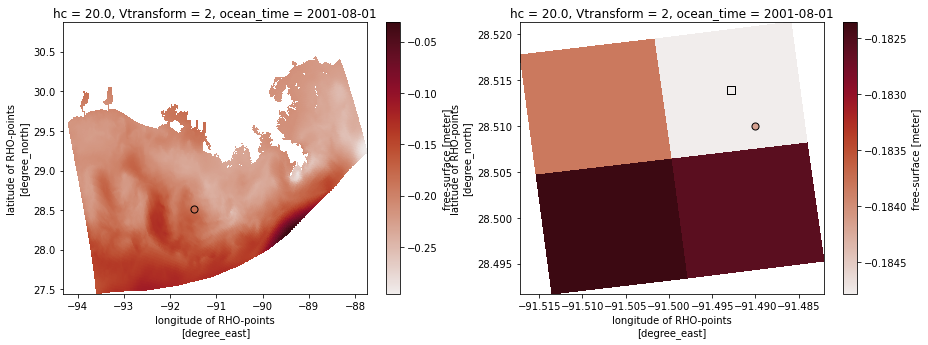

In [9]:
varname = 'zeta'

# sel
longitude = -91.49
latitude = 28.510

# isel
iZ = None
iT = 0
isel = dict(T=iT)

# Interpolation
da_out = ds[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ)

# Selection of nearest location in 2D
da_sel = ds[varname].em.sel2d(longitude, latitude, iT=iT, iZ=iZ)

# Plot
cmap = ds[varname].cmo.seq
dacheck = ds[varname].cf.isel(isel)
fig, axes = plt.subplots(1, 2, figsize=(15,5))

dacheck.cmo.cfplot(ax=axes[0], x='longitude', y='latitude')
axes[0].scatter(da_out.cf['longitude'], da_out.cf['latitude'], s=50, c=da_out, 
           vmin=dacheck.min().values, vmax=dacheck.max().values, cmap=cmap, edgecolors='k')

# make smaller area of model to show
# want model output only within the box defined by these lat/lon values
dacheck_min = dacheck.em.subset([-91.52, 28.49, -91.49, 28.525], drop=True)
dacheck_min.cmo.cfplot(ax=axes[1], x='longitude', y='latitude')
# interpolation
axes[1].scatter(da_out.cf['longitude'], da_out.cf['latitude'], s=50, c=da_out, 
           vmin=dacheck_min.min().values, vmax=dacheck_min.max().values, 
                cmap=cmap, edgecolors='k')
# selection
axes[1].scatter(da_sel.cf['longitude'], da_sel.cf['latitude'], s=50, c=da_sel, 
           vmin=dacheck_min.min().values, vmax=dacheck_min.max().values, 
                cmap=cmap, edgecolors='k', marker='s')


#### outside domain

Don't extrapolate

In [10]:
varname = 'zeta'

# sel
longitude = -166
latitude = 48
sel = dict(longitude=longitude, latitude=latitude)

# isel
iZ = 0
iT = 0
isel = dict(Z=iZ, T=iT)

da_out = ds[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ, extrap=False)

da_out

AssertionError: the input longitude range is outside the model domain

Extrapolate

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


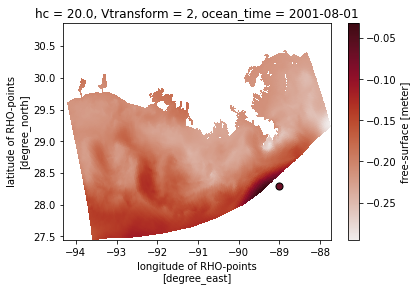

In [11]:
varname = 'zeta'

# sel
longitude = -89
latitude = 28.3
sel = dict(longitude=longitude, latitude=latitude)

# isel
iZ = None
iT = 0
isel = dict(T=iT)

da_out = ds[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ, extrap=True)

# plot
cmap = ds[varname].cmo.seq
dacheck = ds[varname].cf.isel(isel)
fig, ax = plt.subplots(1,1)
dacheck.cmo.cfplot(ax=ax, x='longitude', y='latitude')
ax.scatter(da_out.cf['longitude'], da_out.cf['latitude'], s=50, c=da_out, 
           vmin=dacheck.min().values, vmax=dacheck.max().values, cmap=cmap, edgecolors='k')


### points (locstream, interpolation)

Interpolate to unstructured pairs of lon/lat locations instead of grids of lon/lat locations, using `locstream`. Choose grid points so that we can check the accuracy of the results.

In [12]:
varname = 'zeta'

# sel
# this creates 12 pairs of lon/lat points that 
# align with grid points so we can check the 
# interpolation
longitude = ds[varname].cf['longitude'].isel(eta_rho=60, xi_rho=slice(None,None,10))
latitude = ds[varname].cf['latitude'].isel(eta_rho=60, xi_rho=slice(None,None,10))
sel = dict(X=longitude.xi_rho, Y=longitude.eta_rho)

# isel
iZ = None
iT = 0
isel = dict(T=iT)

da_out = ds[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ, locstream=True)

# check
da_check = ds[varname].cf.isel(isel).cf.sel(sel)

assert np.allclose(da_out, da_check, equal_nan=True)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


It is not currently possible to interpolate in depth with both more than one time and location. 

In [13]:
ds['salt'].em.interp2d(longitude, latitude, Z=-10, locstream=True)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


NotImplementedError: Currently it is not possible to interpolate in depth with more than 1 other (time) dimension.

### grid of known locations (interpolation)

In [14]:
varname = 'zeta'

# sel
longitude = ds[varname].cf['longitude'][:-50:20,:-200:100]
latitude = ds[varname].cf['latitude'][:-50:20,:-200:100]
sel = dict(X=longitude.xi_rho, Y=longitude.eta_rho)

# isel
iZ = None
iT = 0
isel = dict(T=iT)

da_out = ds[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ, locstream=False)

# check
da_check = ds[varname].cf.sel(sel).cf.isel(isel)

assert np.allclose(da_out, da_check)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


### grid of new locations (interpolation, regridding)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


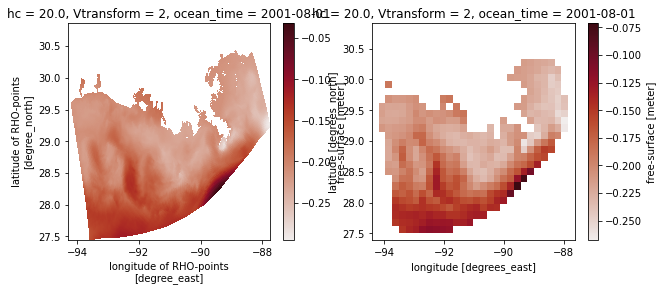

In [15]:
varname = 'zeta'

# sel
longitude = np.linspace(ds[varname].cf['longitude'].min(), ds[varname].cf['longitude'].max(), 30)
latitude = np.linspace(ds[varname].cf['latitude'].min(), ds[varname].cf['latitude'].max(), 30)

# isel
iZ = None
iT = 0
isel = dict(T=iT)

da_out = ds[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ, locstream=False, extrap=False, extrap_val=np.nan)

# plot
cmap = cmo.delta
dacheck = ds[varname].cf.isel(isel)

fig, axes = plt.subplots(1,2, figsize=(10,4))
dacheck.cmo.cfplot(ax=axes[0], x='longitude', y='latitude')
da_out.cmo.cfplot(ax=axes[1], x='longitude', y='latitude')


## MOM6

In [16]:
dataurl = 'http://35.188.34.63:8080/thredds/dodsC/OM4p5/'

ds = xr.open_dataset(f'{dataurl}/ocean_monthly_z.200301-200712.nc4',
                     chunks={'time':1, 'z_l': 1}, drop_variables=['average_DT',
                                                                  'average_T1',
                                                                  'average_T2'])
ds

<xarray.Dataset>
Dimensions:       (nv: 2, time: 60, xh: 720, xq: 720, yh: 576, yq: 576, z_i: 36, z_l: 35)
Coordinates:
  * nv            (nv) float64 1.0 2.0
  * xh            (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * xq            (xq) float64 -299.5 -299.0 -298.5 -298.0 ... 59.0 59.5 60.0
  * yh            (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * yq            (yq) float64 -77.82 -77.63 -77.45 -77.26 ... 89.58 89.79 90.0
  * z_i           (z_i) float64 0.0 5.0 15.0 25.0 ... 5.75e+03 6.25e+03 6.75e+03
  * z_l           (z_l) float64 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
  * time          (time) object 2003-01-16 12:00:00 ... 2007-12-16 12:00:00
Data variables: (12/36)
    Coriolis      (yq, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    areacello     (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    areacello_bu  (yq, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    areacello_cu  (yh, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    areacello_cv  (yq, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    deptho        (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    ...            ...
    umo           (time, z_l, yh, xq) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    uo            (time, z_l, yh, xq) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    vmo           (time, z_l, yq, xh) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    vo            (time, z_l, yq, xh) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    volcello      (time, z_l, yh, xh) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    zos           (time, yh, xh) float32 dask.array<chunksize=(1, 576, 720), meta=np.ndarray>
Attributes:
    filename:                        ocean_monthly.200301-200712.zos.nc
    title:                           OM4p5_IAF_BLING_CFC_abio_csf_mle200
    associated_files:                areacello: 20030101.ocean_static.nc
    grid_type:                       regular
    grid_tile:                       N/A
    external_variables:              areacello
    DODS_EXTRA.Unlimited_Dimension:  time

### grid point

#### horizontal interp, vertical and time isel

In [17]:
varname = 'uo'  # this name should match the custom_criteria for xarray (see __init__)

# sel
longitude = float(ds[varname].cf['X'][100])
latitude = float(ds[varname].cf['Y'][100])
sel = dict(longitude=longitude, latitude=latitude)

# isel
iZ = 0
iT = 0
isel = dict(Z=iZ, T=iT)

da_out = ds[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ)

# check
da_check = ds[varname].cf.sel(sel).cf.isel(isel)

assert np.allclose(da_out, da_check)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


#### horizontal and vertical interp, time isel

In [18]:
varname = 'uo'

# sel
longitude = float(ds[varname].cf['X'][100])
latitude = float(ds[varname].cf['Y'][100])
Z = float(ds[varname].cf['Z'][0])
sel = dict(longitude=longitude, latitude=latitude, Z=Z)

# isel
iT = 0
isel = dict(T=iT)

da_out = ds[varname].em.interp2d(longitude, latitude, iT=iT, Z=Z)

# check
da_check = ds[varname].cf.sel(sel).cf.isel(isel)

assert np.allclose(da_out, da_check)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


### not grid point

#### inside domain

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


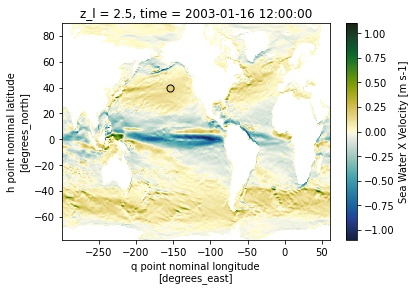

In [19]:
varname = 'uo'

# sel
longitude = -155
latitude = 40
sel = dict(longitude=longitude, latitude=latitude)

# isel
iZ = 0
iT = 0
isel = dict(Z=iZ, T=iT)

da_out = ds[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ)

# plot
cmap = cmo.delta
dacheck = ds[varname].cf.isel(isel)
fig, ax = plt.subplots(1,1)
dacheck.cmo.plot(ax=ax)
ax.scatter(da_out.cf['longitude'], da_out.cf['latitude'], s=50, c=da_out, 
           vmin=dacheck.min().values, vmax=dacheck.max().values, cmap=cmap, edgecolors='k')

#### outside domain

Skipping this section since the model output is global.

### points (locstream)

Unstructured pairs of lon/lat locations instead of grids of lon/lat locations, using `locstream`.

In [20]:
varname = 'uo'

# sel
# this creates 12 pairs of lon/lat points that 
# align with grid points so we can check the 
# interpolation
longitude = ds[varname].cf['X'][::26].values
latitude = ds[varname].cf['Y'][::21].values
# selecting individual lon/lat locations with advanced xarray indexing
sel = dict(longitude=xr.DataArray(longitude, dims="pts"), latitude=xr.DataArray(latitude, dims="pts"))

# isel
iZ = 1
iT = 0
isel = dict(Z=iZ, T=iT)

da_out = ds[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ, locstream=True)

# check
da_check = ds[varname].cf.isel(isel).cf.sel(sel)

assert np.allclose(da_out, da_check, equal_nan=True)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


### grid of known locations

In [21]:
varname = 'uo'

# sel
longitude = ds[varname].cf['X'][100:105]
latitude = ds[varname].cf['Y'][100:106]
sel = dict(longitude=longitude, latitude=latitude)

# isel
iZ = 0
iT = 0
isel = dict(Z=iZ, T=iT)

da_out = ds[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ, locstream=False)

# check
da_check = ds[varname].cf.sel(sel).cf.isel(isel)

assert np.allclose(da_out, da_check)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


### grid of new locations

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


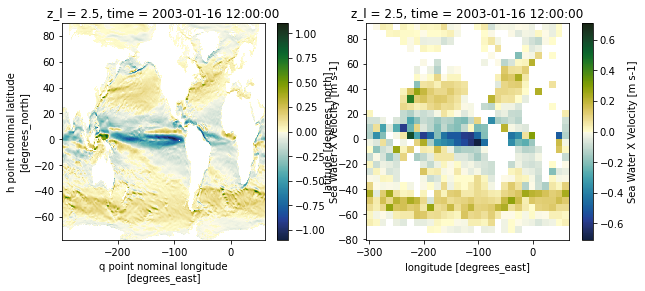

In [22]:
varname = 'uo'

# sel
longitude = np.linspace(ds[varname].cf['X'].min(), ds.cf[varname].cf['X'].max(), 30)
latitude = np.linspace(ds[varname].cf['Y'].min(), ds.cf[varname].cf['Y'].max(), 30)
sel = dict(longitude=longitude, latitude=latitude)

# isel
iZ = 0
iT = 0
isel = dict(Z=iZ, T=iT)

da_out = ds[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ, extrap=False, extrap_val=np.nan)

# plot
cmap = cmo.delta
dacheck = ds[varname].cf.isel(isel)

fig, axes = plt.subplots(1,2, figsize=(10,4))
dacheck.cmo.plot(ax=axes[0])
da_out.cmo.plot(ax=axes[1])


## HYCOM

In [23]:
# url = ['http://tds.hycom.org/thredds/dodsC/GLBy0.08/latest']
# ds = xr.open_mfdataset(url, preprocess=em.preprocess, drop_variables='tau')
# ds.isel(time=slice(0,2)).sel(lat=slice(-20, 30), lon=slice(140,190)).to_netcdf('hycom.nc')
ds = xr.open_mfdataset('hycom.nc', preprocess=em.preprocess)
# ds = ds.order

# url = '/Users/kthyng/Downloads/hycom.nc'
# xrargs = {'decode_times': False}
# ds = xr.open_dataset(url, **xrargs)

### grid point

In [24]:
varname = 'water_u'

# sel
longitude = float(ds[varname].cf['X'][100])
latitude = float(ds[varname].cf['Y'][150])
sel = dict(longitude=longitude, latitude=latitude)

# isel
iZ = 0
iT = None
isel = dict(Z=iZ)

da_out = ds[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ)

# check
da_check = ds[varname].cf.sel(sel).cf.isel(isel)

assert np.allclose(da_out, da_check)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


### not grid point

#### inside domain

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


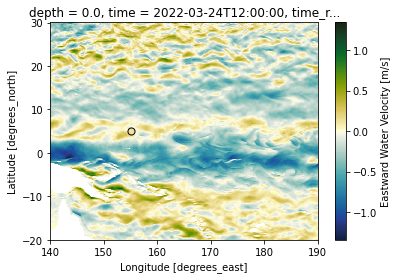

In [25]:
varname = 'water_u'

# sel
longitude = 155
latitude = 5
sel = dict(longitude=longitude, latitude=latitude)

# isel
iZ = 0
iT = 0
isel = dict(Z=iZ, T=iT)

da_out = ds[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ)

# plot
cmap = cmo.delta
dacheck = ds[varname].cf.isel(isel)
fig, ax = plt.subplots(1,1)
dacheck.cmo.plot(ax=ax)
ax.scatter(da_out.cf['longitude'], da_out.cf['latitude'], s=50, c=da_out, 
           vmin=dacheck.min().values, vmax=dacheck.max().values, cmap=cmap, edgecolors='k')

#### outside domain

Don't extrapolate

In [26]:
varname = 'water_u'

# sel
longitude = -166
latitude = 48
sel = dict(longitude=longitude, latitude=latitude)

# isel
iZ = 0
iT = 0
isel = dict(Z=iZ, T=iT)

da_out = ds[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ, extrap=False)

da_out = em.select(**kwargs)
da_out

AssertionError: the input longitude range is outside the model domain

Extrapolate

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


(138.0, 190.0)

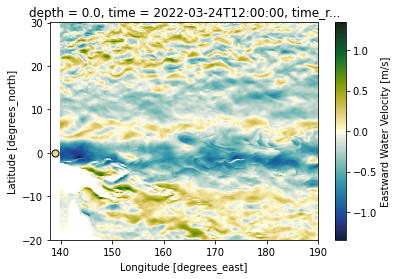

In [27]:
varname = 'water_u'

# sel
longitude = 139
latitude = 0
sel = dict(longitude=longitude, latitude=latitude)

# isel
iZ = 0
iT = 0
isel = dict(Z=iZ, T=iT)

da_out = ds[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ, extrap=True)

# plot
cmap = cmo.delta
dacheck = ds[varname].cf.isel(isel)
fig, ax = plt.subplots(1,1)
dacheck.cmo.plot(ax=ax)
ax.scatter(da_out.cf['longitude'], da_out.cf['latitude'], s=50, c=da_out, 
           vmin=dacheck.min().values, vmax=dacheck.max().values, cmap=cmap, edgecolors='k')

ax.set_xlim(138,190)

### points (locstream)

Unstructured pairs of lon/lat locations instead of grids of lon/lat locations, using `locstream`.

In [28]:
varname = 'water_u'

# sel
# this creates 12 pairs of lon/lat points that 
# align with grid points so we can check the 
# interpolation
longitude = ds[varname].cf['X'][::40].values
latitude = ds[varname].cf['Y'][::80].values
# selecting individual lon/lat locations with advanced xarray indexing
sel = dict(longitude=xr.DataArray(longitude, dims="pts"), latitude=xr.DataArray(latitude, dims="pts"))

# isel
iZ = 0
iT = 0
isel = dict(Z=iZ, T=iT)

da_out = ds[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ, locstream=True)

# check
da_check = ds[varname].cf.isel(isel).cf.sel(sel)

assert np.allclose(da_out, da_check, equal_nan=True)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


### grid of known locations

In [29]:
varname = 'water_u'

# sel
longitude = ds[varname].cf['X'][100::500]
latitude = ds[varname].cf['Y'][100::500]
sel = dict(longitude=longitude, latitude=latitude)

# isel
iZ = 0
iT = None
isel = dict(Z=iZ)

da_out = ds[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ, locstream=False)

# check
da_check = ds[varname].cf.sel(sel).cf.isel(isel)

assert np.allclose(da_out, da_check)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


### grid of new locations

/Users/kthyng/packages/cf-xarray/cf_xarray/accessor.py:1530: UserWarning: Variables {''} not found in object but are referred to in the CF attributes.
  warnings.warn(
/Users/kthyng/packages/cf-xarray/cf_xarray/accessor.py:1530: UserWarning: Variables {''} not found in object but are referred to in the CF attributes.
  warnings.warn(
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


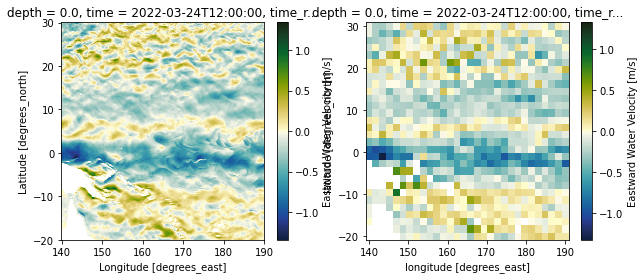

In [30]:
varname = 'water_u'

# sel
longitude = np.linspace(ds[varname].cf['X'].min(), ds.cf[varname].cf['X'].max(), 30)
latitude = np.linspace(ds[varname].cf['Y'].min(), ds.cf[varname].cf['Y'].max(), 30)
sel = dict(longitude=longitude, latitude=latitude)

# isel
iZ = 0
iT = 0
isel = dict(Z=iZ, T=iT)

da_out = ds[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ, locstream=False)
# kwargs = dict(da=ds[varname], longitude=longitude, latitude=latitude, iT=T, iZ=Z)

# da_out = em.select(**kwargs)

# plot
cmap = cmo.delta
dacheck = ds[varname].cf.isel(isel)

fig, axes = plt.subplots(1,2, figsize=(10,4))
dacheck.cmo.plot(ax=axes[0])
da_out.cmo.plot(ax=axes[1])


## POM

In [31]:
url = ['https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/LOOFS/fmrc/Aggregated_7_day_LOOFS_Fields_Forecast_best.ncd']
ds = xr.open_mfdataset(url, preprocess=em.preprocess)
ds

<xarray.Dataset>
Dimensions:      (nx: 61, ny: 25, sigma: 20, time: 252, time_1: 60)
Coordinates:
    lon          (ny, nx) float32 dask.array<chunksize=(25, 61), meta=np.ndarray>
    lat          (ny, nx) float32 dask.array<chunksize=(25, 61), meta=np.ndarray>
  * sigma        (sigma) float32 0.0 0.0227 0.0454 0.0681 ... 0.8853 0.9534 1.0
  * time         (time) datetime64[ns] 2022-03-24T12:59:45.938400 ... 2022-04-04
    time_run     (time) datetime64[ns] dask.array<chunksize=(252,), meta=np.ndarray>
  * nx           (nx) int64 0 1 2 3 4 5 6 7 8 9 ... 52 53 54 55 56 57 58 59 60
  * ny           (ny) int64 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
    z            (time, sigma, ny, nx) float32 dask.array<chunksize=(252, 20, 25, 61), meta=np.ndarray>
Dimensions without coordinates: time_1
Data variables:
    validtime    (time_1) |S64 dask.array<chunksize=(60,), meta=np.ndarray>
    mask         (ny, nx) float32 dask.array<chunksize=(25, 61), meta=np.ndarray>
    depth        (ny, nx) float32 dask.array<chunksize=(25, 61), meta=np.ndarray>
    zeta         (time, ny, nx) float32 dask.array<chunksize=(252, 25, 61), meta=np.ndarray>
    air_u        (time, ny, nx) float32 dask.array<chunksize=(252, 25, 61), meta=np.ndarray>
    air_v        (time, ny, nx) float32 dask.array<chunksize=(252, 25, 61), meta=np.ndarray>
    u            (time, sigma, ny, nx) float32 dask.array<chunksize=(252, 20, 25, 61), meta=np.ndarray>
    v            (time, sigma, ny, nx) float32 dask.array<chunksize=(252, 20, 25, 61), meta=np.ndarray>
    temp         (time, sigma, ny, nx) float32 dask.array<chunksize=(252, 20, 25, 61), meta=np.ndarray>
    time_offset  (time) datetime64[ns] dask.array<chunksize=(252,), meta=np.ndarray>
Attributes: (12/21)
    datum1:            reference to LWD=zeta
    datum2:            reference to IGLD85=zeta - IGLD85
    file_type:         Full_Grid
    Conventions:       CF-1.4
    grid_type:         rectilinear
    z_type:            2-D
    ...                ...
    _CoordSysBuilder:  ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:     GRID
    featureType:       GRID
    location:          Proto fmrc:Aggregated_7_day_LOOFS_Fields_Forecast
    DODS.strlen:       19
    DODS.dimName:      validtime_len

In [32]:
ds.cf.describe()

Coordinates:
- CF Axes: * X: ['nx']
           * Y: ['ny']
           * Z: ['sigma']
           * T: ['time']

- CF Coordinates:   longitude: ['lon']
                    latitude: ['lat']
                    vertical: ['sigma', 'z']
                  * time: ['time']

- Cell Measures:   area, volume: n/a

- Standard Names:   forecast_reference_time: ['time_run']
                    latitude: ['lat']
                    longitude: ['lon']
                  * ocean_sigma_coordinate: ['sigma']
                  * time: ['time']

- Bounds:   n/a

Data Variables:
- Cell Measures:   area, volume: n/a

- Standard Names:   depth: ['depth']
                    eastward_sea_water_velocity: ['u']
                    eastward_wind: ['air_u']
                    forecast_period: ['time_offset']
                    northward_sea_water_velocity: ['v']
                    northward_wind: ['air_v']
                    sea_surface_elevation: ['zeta']
                    sea_water_temperature: ['temp']



### grid point

In [33]:
%%time
varname = 'zeta'

# Set up a single lon/lat location
j, i = 10, 10
longitude = float(ds[varname].cf['longitude'][j,i])
latitude = float(ds[varname].cf['latitude'][j,i])

# Select-by-index a time index and no vertical index (zeta has none)
# also lon/lat by index
Z = None
iT = 0
isel = dict(T=iT, X=i, Y=j)

da_out = ds[varname].em.interp2d(longitude, latitude, iT=iT, iZ=Z)

# check work
da_check = ds[varname].cf.isel(isel)

assert np.allclose(da_out, da_check)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


CPU times: user 247 ms, sys: 20.4 ms, total: 268 ms
Wall time: 820 ms


This is faster the second time the regridder is used — it is saved by the `extract_model` accessor and reused if the lon/lat locations to be interpolated to are the same. Here we interpolate to salinity and it is faster than it was the first time it was used for interpolation the sea surface elevation.

In [34]:
varname = 'temp'

# Set up a single lon/lat location
j, i = 10, 10
longitude = float(ds[varname].cf['longitude'][j,i])
latitude = float(ds[varname].cf['latitude'][j,i])

# Select-by-index a time index and no vertical index (zeta has none)
# also lon/lat by index
iZ = 0
iT = 0
isel = dict(T=iT, Z=iZ, X=i, Y=j)

da_out = ds[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ)

# check work
da_check = ds[varname].cf.isel(isel)

assert np.allclose(da_out, da_check)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


### not grid point

#### inside domain

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


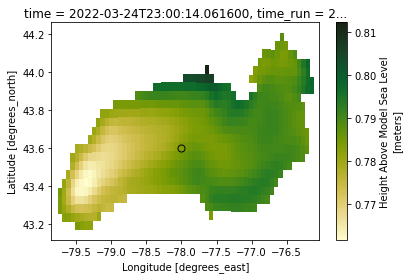

In [44]:
varname = 'zeta'

# sel
longitude = -78.0
latitude = 43.6

# isel
iZ = None
iT = 10
isel = dict(T=iT)

da_out = ds[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ)

# plot
cmap = ds[varname].cmo.seq
dacheck = ds[varname].cf.isel(isel)
fig, ax = plt.subplots(1,1)
dacheck.cmo.cfplot(ax=ax, x='longitude', y='latitude')
ax.scatter(da_out.cf['longitude'], da_out.cf['latitude'], s=50, c=da_out, 
           vmin=dacheck.min().values, vmax=dacheck.max().values, cmap=cmap, edgecolors='k')

### points (locstream)

Unstructured pairs of lon/lat locations instead of grids of lon/lat locations, using `locstream`.

In [49]:
varname = 'zeta'

# sel
# this creates 12 pairs of lon/lat points that 
# align with grid points so we can check the 
# interpolation
longitude = ds[varname].cf['longitude'].cf.isel(Y=20, X=slice(None, None, 10))
latitude = ds[varname].cf['latitude'].cf.isel(Y=20, X=slice(None, None, 10))
sel = dict(X=longitude.cf['X'], Y=longitude.cf['Y'])

# isel
iZ = None
iT = 0
isel = dict(T=iT)

da_out = ds[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ, locstream=True)

# check
da_check = ds[varname].cf.isel(isel).cf.sel(sel)

assert np.allclose(da_out, da_check, equal_nan=True)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


### grid of new locations

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


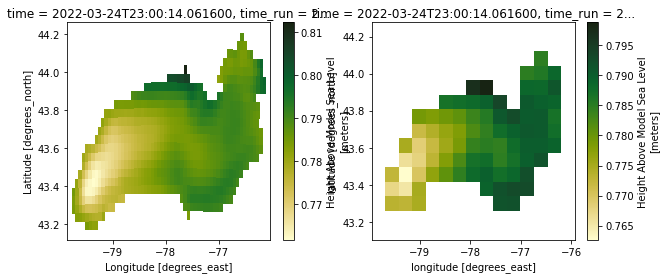

In [51]:
varname = 'zeta'

# sel
longitude = np.linspace(ds[varname].cf['longitude'].min(), ds[varname].cf['longitude'].max(), 15)
latitude = np.linspace(ds[varname].cf['latitude'].min(), ds[varname].cf['latitude'].max(), 15)

# isel
iZ = None
iT = 10
isel = dict(T=iT)

da_out = ds[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ, locstream=False, extrap=False, extrap_val=np.nan)

# plot
cmap = cmo.delta
dacheck = ds[varname].cf.isel(isel)

fig, axes = plt.subplots(1,2, figsize=(10,4))
dacheck.cmo.cfplot(ax=axes[0], x='longitude', y='latitude')
da_out.cmo.cfplot(ax=axes[1], x='longitude', y='latitude')
